# Convolutional Neural Networks with Keras (1)

## CNN from scratch

We will train our CNN to distinguish ants and bees

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8

http://cs231n.github.io/transfer-learning/

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

The dataset can be downloaded from

It uses the following directory structure:

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np
        
from IPython.display import Image
from IPython.display import display

import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,14)

Using TensorFlow backend.


In [2]:
train_data_dir = 'data/train'
test_data_dir = 'data/test'

num_epochs = 50
batch_size = 16

n_train_samples = 235
n_train_ants = 114
n_train_bees = 121

n_test_samples = 148
n_test_ants = 66
n_test_bees = 82

model_exists = False
model_name = "cnn_from_scratch.h5"

In [3]:
target_width = 500
target_height = 375

In [4]:
# We need to scale all images to the same size (at least all in a batch; see https://github.com/fchollet/keras/issues/1920)
rootdir = './data'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        path = (os.path.join(subdir, file))
        with Image.open(path) as img:
            width, height = img.size
            
            # very few images were super large --> remove
            if width > 500 or width < 300: os.remove(path)
            
            # crop all others to common length (resize was avoided because of distortion)
            if not (width == target_width and height == target_height):
              resized =  img.crop((0,0,target_width,target_height))
              resized.save(path)



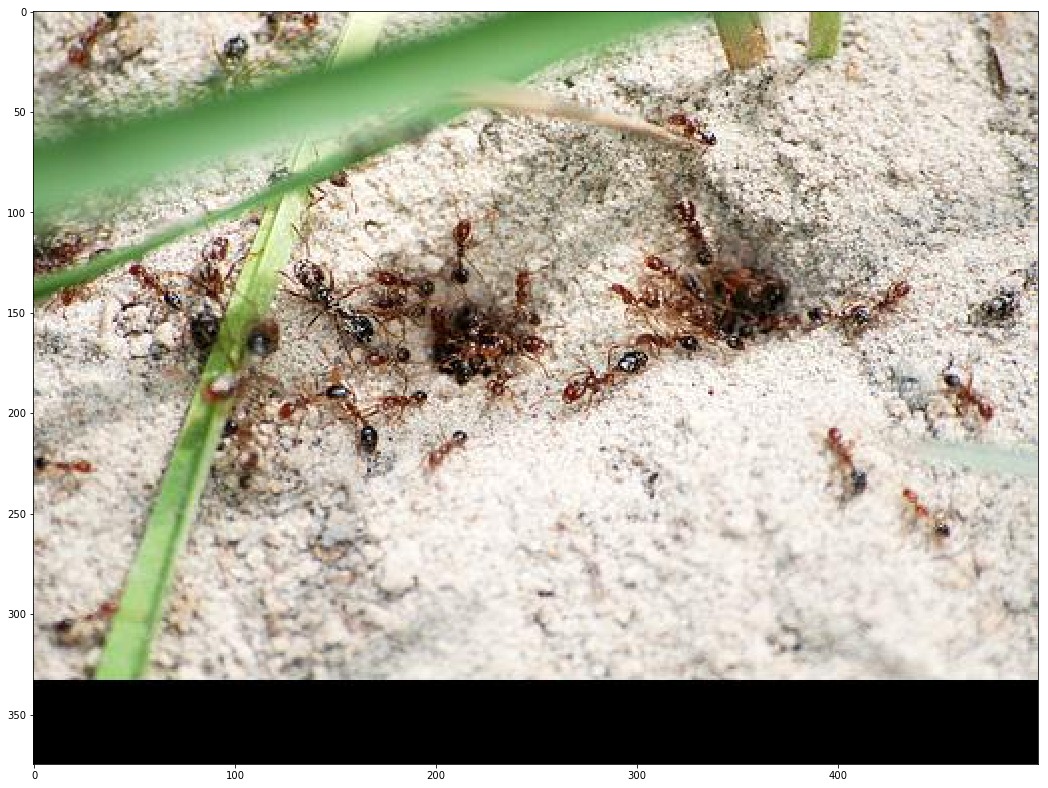

In [5]:
# display an example image
path = 'data/train/ants/1030023514_aad5c608f9.jpg'

# using matplotlib
img_mpl = mpimg.imread(path)
plt.imshow(img_mpl)     

# could also do
# img = load_img(path)
# img

In [6]:
# get image as a numpy array
img = load_img(path)
img_array = img_to_array(img)  
img_array.shape

(375, 500, 3)

We will need to reshape the images to the shape required by Keras Conv layer, which is 4-dimensional.

In [7]:
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

(1, 375, 500, 3)

### Data augmentation

For an image classification task like this, the dataset is extremely small.
We can artificially generate more data applying transformations like rotation, shifting, zoom, etc.

In [8]:
# rotation_range: 0 - 180 degrees 
# width_shift / height_shift: bounds (as a fraction of total width or height) on horizontal/vertical translation
# rescale: multiplication factor for pixel values 
# shear_range: randomly applied shearing transformations
# zoom_range: randomly zooming inside pictures
# horizontal_flip: randomly flipping half of the images horizontally
# fill_mode: strategy used for filling in newly created pixels (after a rotation or a width/height shift)

datagen = ImageDataGenerator(
        #rotation_range=40
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
        #fill_mode='nearest'
)

img = load_img(path)  
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape) 

preview_dir = "preview"
i = 0
filelist = [ f for f in os.listdir(preview_dir)]
for f in filelist:
    os.remove(os.path.join("preview",f))
    
for batch in datagen.flow(img_array,
                          batch_size=1,
                          save_to_dir=preview_dir,
                          save_prefix='i',
                          save_format='jpg'):
    i += 1
    if i > 10:
        break  


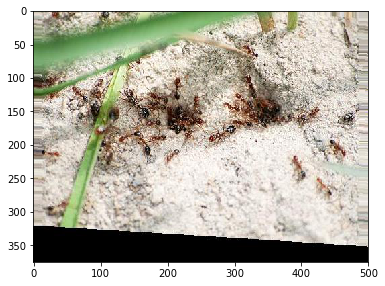

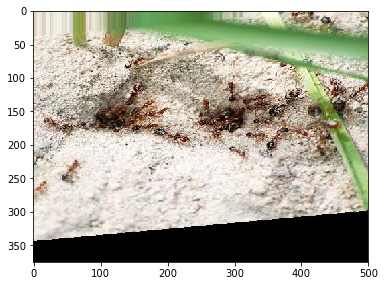

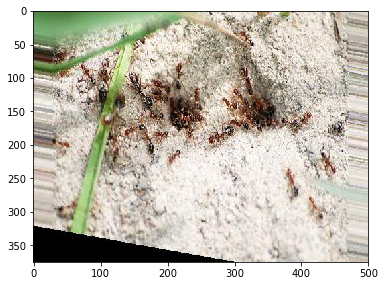

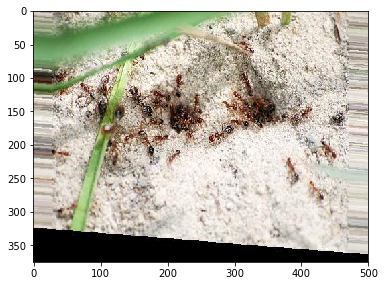

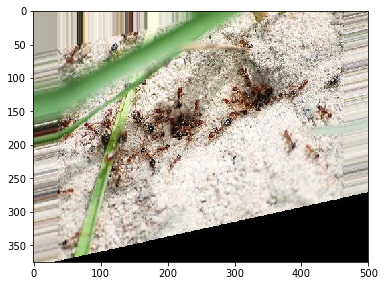

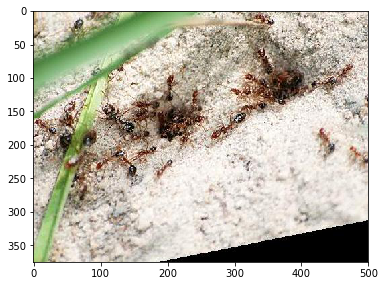

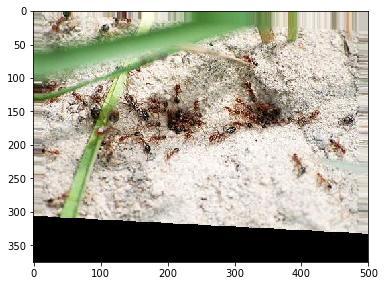

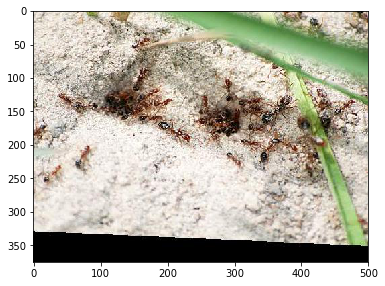

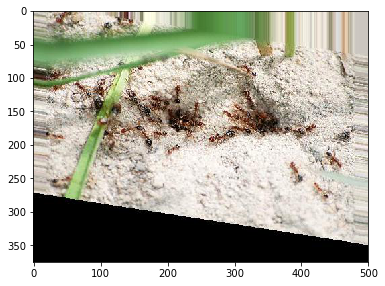

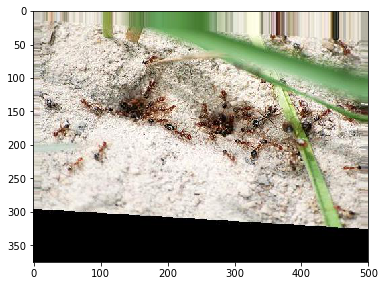

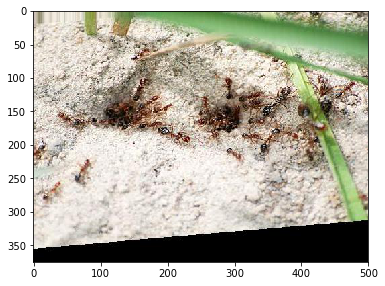

In [9]:
paths = os.listdir(preview_dir)
transformed_images = [mpimg.imread(os.path.join("preview",path)) for path in paths]
for img in transformed_images:
    plt.figure(figsize=(6,6))
    plt.imshow(img)

In [10]:
# Input shape
# 4D tensor with shape: (samples, channels, rows, cols) if data_format='channels_first' or
# 4D tensor with shape: (samples, rows, cols, channels) if data_format='channels_last'.
print(K.image_data_format())

# this is opposite from PIL convention width, height!
input_shape = (target_height, target_width, 3)
target_size = (target_height, target_width)
print("input shape: {}".format(input_shape))
print("target size: {}".format(target_size))

channels_last
input shape: (375, 500, 3)
target size: (375, 500)


In [11]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
     # rotation_range=40,
     # width_shift_range=0.2,
     # height_shift_range=0.2,
     rescale=1. / 255,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True)

In [12]:
# for test, rescale only
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary')

Found 235 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [14]:
if not model_exists:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 373, 498, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 373, 498, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 186, 249, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 184, 247, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 184, 247, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 92, 123, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 121, 64)       18496     
__________

In [15]:
if not model_exists:
    model.fit_generator(
        train_generator,
        steps_per_epoch=n_train_samples // batch_size,
        epochs=num_epochs,
        validation_data=validation_generator,
        validation_steps=n_test_samples // batch_size)

Epoch 1/50
14/14 [==============================] - 71s - loss: 1.6385 - acc: 0.5402 - val_loss: 0.6877 - val_acc: 0.5556
Epoch 2/50
14/14 [==============================] - 68s - loss: 0.7088 - acc: 0.5740 - val_loss: 0.7953 - val_acc: 0.5606
Epoch 3/50
14/14 [==============================] - 69s - loss: 0.6973 - acc: 0.5888 - val_loss: 1.1126 - val_acc: 0.4470
Epoch 4/50
14/14 [==============================] - 68s - loss: 0.6733 - acc: 0.6060 - val_loss: 0.7991 - val_acc: 0.5303
Epoch 5/50
14/14 [==============================] - 68s - loss: 0.8367 - acc: 0.5804 - val_loss: 0.6394 - val_acc: 0.6591
Epoch 6/50
14/14 [==============================] - 68s - loss: 0.6713 - acc: 0.5959 - val_loss: 0.6214 - val_acc: 0.7121
Epoch 7/50
14/14 [==============================] - 69s - loss: 0.6270 - acc: 0.6277 - val_loss: 0.6969 - val_acc: 0.5758
Epoch 8/50
14/14 [==============================] - 68s - loss: 0.6167 - acc: 0.6201 - val_loss: 0.7730 - val_acc: 0.5833
Epoch 9/50
14/14 [======

In [16]:
if not model_exists:
    model.save(model_name)

In [17]:
if model_exists:
    model = load_model(model_name)
    model.summary()

### Get predictions

Diagnosis: bee (confidence: 1.00)


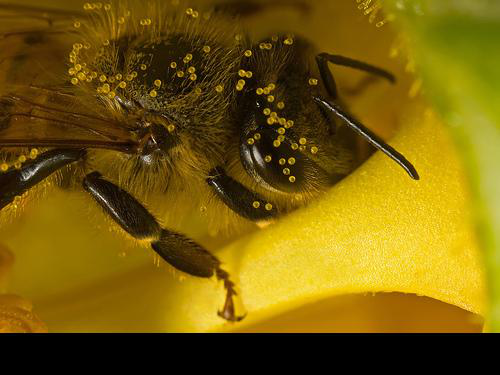

In [18]:
test_img_path = 'data/train/bees/1092977343_cb42b38d62.jpg'
img = load_img(test_img_path) 
candidate = np.expand_dims(img_to_array(img)/255, axis=0)
pred, prob = model.predict_classes(candidate, verbose=0), model.predict_proba(candidate, batch_size=1, verbose=0)
class_ = "ant" if pred[0,0] == 0 else "bee"
conf = 1 - prob[0,0] if pred[0,0] == 0 else prob[0,0]
print('Diagnosis: {} (confidence: {:.2f})'.format(class_,conf))
img

In [19]:
def score_img(img_path):
    img = load_img(img_path) 
    candidate = np.expand_dims(img_to_array(img)/255, axis=0)
    pred = model.predict_classes(candidate, verbose=0)
    return pred[0,0]

In [20]:
num_ants_found = 0
ants_dir = os.path.join(test_data_dir, "ants")
for imgfile in os.listdir(ants_dir):
    score = score_img(os.path.join(ants_dir, imgfile))
    if score == 0: num_ants_found = num_ants_found + 1
print('Detected ant in {} of {} images'.format(num_ants_found, n_test_ants))

Detected ant in 55 of 66 images


In [21]:
num_bees_found = 0
bees_dir = os.path.join(test_data_dir, "bees")
for imgfile in os.listdir(bees_dir):
    score = score_img(os.path.join(bees_dir, imgfile))
    if score == 1: num_bees_found = num_bees_found + 1
print('Detected bee in {} of {} images'.format(num_bees_found, n_test_bees))

Detected bee in 38 of 82 images


In [22]:
# let's say ants are positive
true_positives = num_ants_found
false_negatives = n_test_ants - true_positives
true_negatives = num_bees_found
false_positives = n_test_bees - true_negatives

accuracy = (true_positives + true_negatives) / (n_test_ants + n_test_bees)
sensitivity = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)

print('Accuracy: {:.3f}, sensitivity: {:.3f}, precision: {:.3f}'.format(accuracy, sensitivity, precision))

Accuracy: 0.628, sensitivity: 0.833, precision: 0.556
